In [20]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [5]:
# Define dataset path
dataset_path = "/content/gdrive/MyDrive/tubes_pcd/"

# Label mapping
labels = {
    "Apple___healthy": 0,
    "Apple___Cedar_apple_rust": 1,
    "Apple___Black_rot": 2,
    "Apple___Apple_scab": 3,
}


In [3]:
def extract_glcm_features(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize for consistency
    gray = cv2.resize(gray, (128, 128))
    # Compute GLCM
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    # Extract GLCM properties
    features = []
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in properties:
        features.append(np.mean(graycoprops(glcm, prop)))
    return features


In [6]:
features = []
targets = []

for label, class_index in labels.items():
    class_path = os.path.join(dataset_path, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            glcm_features = extract_glcm_features(image)
            features.append(glcm_features)
            targets.append(class_index)

# Convert to NumPy arrays
X = np.array(features)
y = np.array(targets)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [9]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7793457344451572
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       424
           1       0.81      0.82      0.82       355
           2       0.80      0.89      0.84       390
           3       0.69      0.54      0.61       390

    accuracy                           0.78      1559
   macro avg       0.77      0.78      0.77      1559
weighted avg       0.77      0.78      0.77      1559



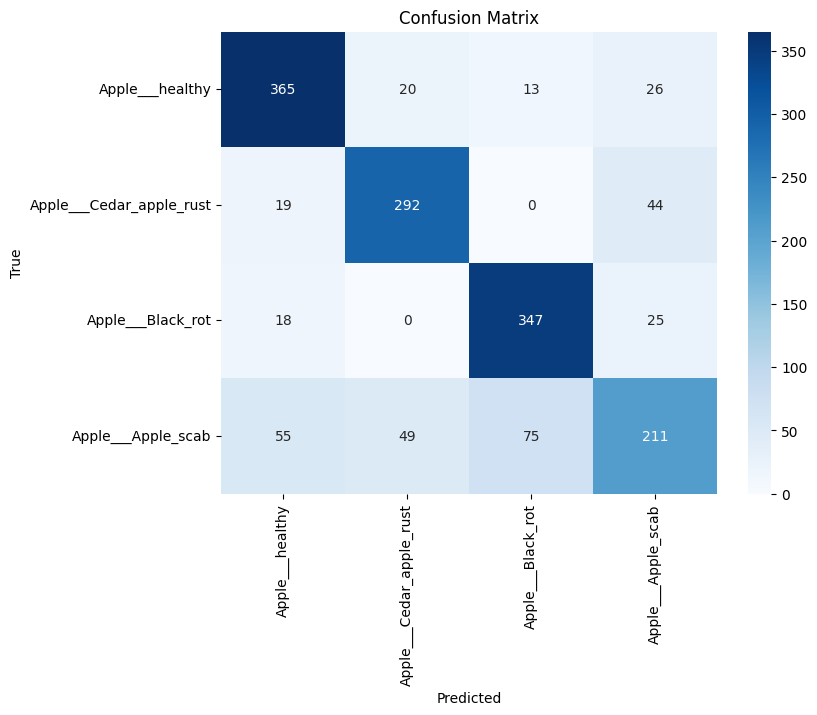

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels.keys(), yticklabels=labels.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [10]:
import joblib

# Save the model for future use
joblib.dump(rf_model, "random_forest_glcm_model.pkl")


['random_forest_glcm_model.pkl']

In [14]:
# Load the model
rf_model = joblib.load("random_forest_glcm_model.pkl")
